<a href="https://colab.research.google.com/github/1900690/analog-meter-reading/blob/main/analog_meter_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title 分析する画像をアップロードまたはサンプル画像で分析

#事前準備
from google.colab import files
import os
import shutil
サンプル画像を使用する = True # @param {type:"boolean"}
#@markdown ※サンプル画像は、分析ごとに５つの画像の中からランダムで１つ選ばれるようになっています。
if サンプル画像を使用する == True:
  if os.path.exists('/content/test-meter-images.zip'):
     os.remove('/content/test-meter-images.zip')
  if os.path.exists('/content/test-meter-images'):
     shutil.rmtree('/content/test-meter-images')
  !wget -q  https://github.com/1900690/analog-meter-reading/releases/download/sample/test-meter-images.zip
  !unzip -q test-meter-images.zip

else:
  uploaded_file = files.upload()
  uploaded_file_name = next(iter(uploaded_file))

Saving 20250412T015012.jpg to 20250412T015012.jpg


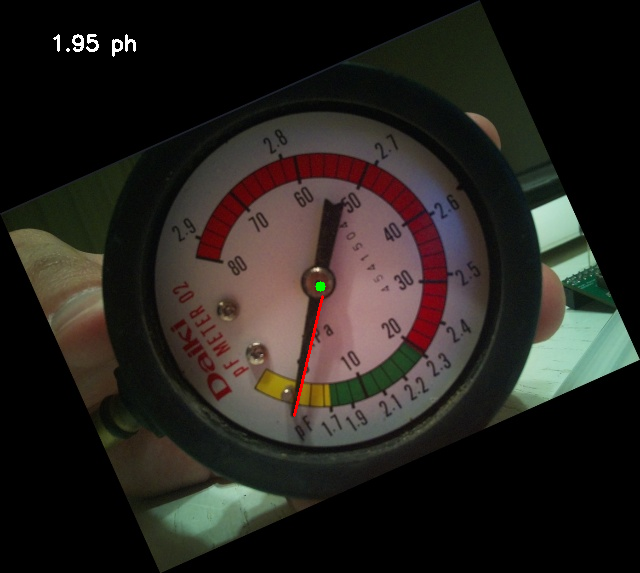

In [ ]:
#@title （旧バージョン）PF値を測定

import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow
import random

# 画像の読み込み
if サンプル画像を使用する == True:
  folder_path = '/content/test-meter-images'
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  random_file = random.choice(files)
  img = cv2.imread(random_file)
else:
  img = cv2.imread(uploaded_file_name)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# エッジ検出
edges = cv2.Canny(gray, 50, 150)

# ハフ変換による直線検出
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

# メーターの中心を推定
center = (img.shape[1] // 2, img.shape[0] // 2)

# 針と考えられる最長の線を見つける
longest_line = None
max_length = 0
angle = None
angle_off_set=-49
angle_correction=180

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # メーターの中心に最も近い点を始点として考える
        if math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2) < math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2):
            start_x, start_y, end_x, end_y = x1, y1, x2, y2
        else:
            start_x, start_y, end_x, end_y = x2, y2, x1, y1

        # メーターの中心からの線のみを考慮
        if length > max_length and math.sqrt((start_x - center[0]) ** 2 + (start_y - center[1]) ** 2) < 50:
            max_length = length
            longest_line = (start_x, start_y, end_x, end_y)
            angle = math.degrees(math.atan2(center[1] - end_y, end_x - center[0]))+angle_off_set+angle_correction
            Kpa=8/27*angle
            if Kpa * 10.197 > 0:
              PH=math.log10(Kpa*10.197)
            else:
              PH=-1

# 針を描画
if longest_line:
    start_x, start_y, end_x, end_y = longest_line
    cv2.line(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
    cv2.circle(img, center, 5, (0, 255, 0), -1)
    if angle_off_set is not None:
      if PH >0:
        cv2.putText(img, f"{PH:.2f} ph", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
      else:
        cv2.putText(img, f"Please reset the angle_off_set", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
# 結果の表示
cv2_imshow(img)

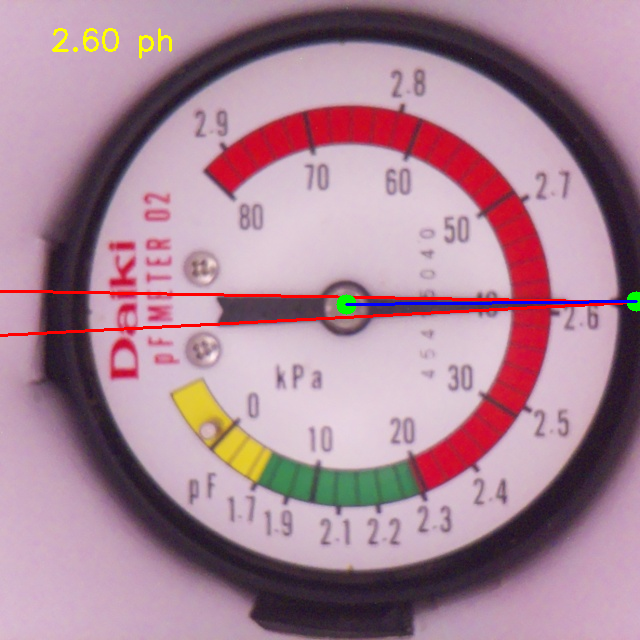

In [28]:
#@title （新バージョン）PF値を測定
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math

# 画像の読み込み
if サンプル画像を使用する == True:
  folder_path = '/content/test-meter-images'
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  random_file = random.choice(files)
  img = cv2.imread(random_file)
else:
  img = cv2.imread(uploaded_file_name)

# 指定する中心点（メータの中心）
cx, cy =(346,304)#横は→に進む、縦は↓に進む
angle_off_set=-133#pf0の時に０になるように初期値を設定する

# グレースケール変換 & 二値化
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold = 100
_, img_thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

# エッジ検出
edges = cv2.Canny(img_thresh, 50, 200, apertureSize=3)

# Hough変換で直線を検出（2本の直線を得る）
minn = None
for m in range(10, 161, 1):
    lines = cv2.HoughLines(edges, 1, np.pi / 180, m)
    if lines is not None and len(lines) == 2:
        minn = m
        break

# 直線が2本見つからなかった場合のエラーハンドリング
if minn is None:
    raise ValueError("直線が2本検出されませんでした。画像のコントラストやエッジ検出のパラメータを調整してください。")

lines = cv2.HoughLines(edges, 1, np.pi / 180, minn)

theta_t = []  # 直線の角度
coefficients = []  # 直線の傾きと切片

for i in range(len(lines)):
    for rho, theta in lines[i]:
        theta_t.append(theta)

        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # x2-x1が0の場合のエラーハンドリング
        if x2 - x1 == 0:
            continue  # 無限傾斜を避ける
        a0 = (y2 - y1) / (x2 - x1)
        b0 = y1 - a0 * x1
        coefficients.append((a0, b0))

# 直線の数をチェック（2本以上ある場合は最初の2本を使用）
if len(coefficients) < 2:
    raise ValueError("十分な直線が検出されませんでした。")

(a1, b1), (a2, b2) = coefficients[:2]  # 最初の2本を選択

# 交点を計算
if a1 == a2:
    raise ValueError("平行な直線のため交点が計算できません。")

x_t = (b2 - b1) / (a1 - a2)
y_t = a1 * x_t + b1

# 交点と中心点を結ぶ線の角度を計算
angle_rad = np.arctan2(y_t - cy, x_t - cx)
angle_deg = np.degrees(angle_rad)
if angle_deg < 0:
    angle_deg += 360  # 負の角度を修正
angle =int(angle_deg) +angle_off_set
Kpa=8/27*angle
if Kpa * 6 > 0:
  PH=math.log10(Kpa*6)
  #PH=math.log10(Kpa*10.197)
elif Kpa == 0 :
  PH=0
else:
  PH=-1

# 結果を画像に描画
cv2.circle(img, (int(cx), int(cy)), 10, (0, 255, 0), -1)  # 中心点を描画
cv2.circle(img, (int(x_t), int(y_t)), 10, (0, 255, 0), -1)  # 交点を描画
cv2.line(img, (cx, cy), (int(x_t), int(y_t)), (255, 0, 0), 2)  # 中心と交点を結ぶ線
cv2.putText(img, f"{PH:.2f} ph", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

cv2.imwrite('meter_angle.jpg', img)
cv2_imshow(img)

##参考文献

1.   [アナログメーターの画像から針の角度を読み取るやつ作ってみた(OpenCV)](https://arkouji.cocolog-nifty.com/blog/2021/09/post-2c82af.html)
2.   [「メーター解析処理」の実装](https://www.primecast.co.jp/columns/8ieb_pgnqe)

